For this task, you are provided ‘recom.csv’ dataset. In this dataset, you have following columns:

•	Main_ID (Customer ID)
•	Transaction_ID
•	Date
•	Price
•	Code_Product
•	Amount (Order Amount)
•	ItemKey

Well, using this data, you are asked to **generate a dataframe in which you recommend an item (or items) for each user**.

Hints: 
1)	Please note that there is no rating in the dataset, but, no worries, there is a way to solve this problem.
2)	If possible, please recommend multiple items per user.
3)	You can consider creating pivot table with ‘Main_ID’, ‘ItemKey’, ‘Transaction_ID’.


# Import libraries

In [78]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# EDA

In [79]:
df = pd.read_csv(r'../data/recom.csv')

In [80]:
df.head()

,Unnamed: 0,Main_ID,Transaction_ID,Date,Price,Code_Product,Amount,ItemKey
0,0,90fada91,264f7a69,2022-10-07 20:53:49.153,125.0,5002.0,1.0,5002.0
1,1,9006f9ac,45c7d853,2022-09-17 15:54:57.187,19.0,35012.0,1.0,NaN
2,2,32270891,61ad76dd,2022-11-28 13:51:55.667,141.0,5005.0,1.0,5005.0
3,3,97e03e47,41ee09f6,2022-09-12 16:20:22.110,4.5,35078.5,1.0,NaN
4,4,41949228,244fe6d8,2022-10-14 18:53:43.933,129.5,49291.5,5.0,NaN


In [81]:
df.shape

(50000, 8)

In [82]:
df.isna().sum()

Unnamed: 0            0
Main_ID               0
Transaction_ID        0
Date                  0
Price                 0
Code_Product          0
Amount                0
ItemKey           21403
dtype: int64

In [83]:
df.duplicated().sum()

0

In [84]:
df['Main_ID'].nunique()

28514

In [85]:
df['Code_Product'].nunique()

333

We have 50,000 transactions, across 28514 customers and 333 products

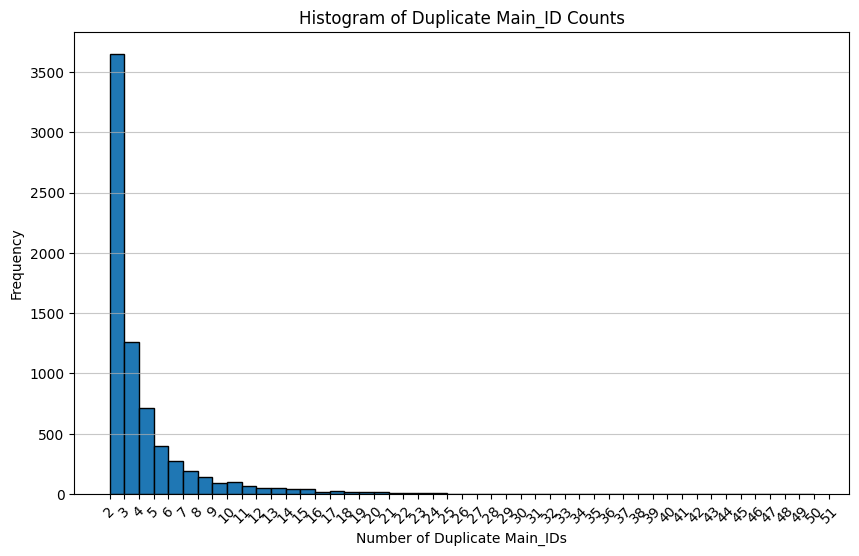

In [86]:
main_id_counts = df['Main_ID'].value_counts()
duplicated_counts = main_id_counts[main_id_counts > 1]

# Create a histogram of the number of rows each duplicated ID has
plt.figure(figsize=(10, 6))
plt.hist(duplicated_counts, bins=range(2, duplicated_counts.max()), edgecolor='black') # start at 2 counts (all are duplicated)
plt.title('Histogram of Duplicate Main_ID Counts')
plt.xlabel('Number of Duplicate Main_IDs')
plt.ylabel('Frequency')
plt.xticks(range(2, duplicated_counts.max() + 1), rotation = 45)
plt.grid(axis='y', alpha=0.7)
plt.show()

In [87]:
len(duplicated_counts)

7243

In [88]:
single_transaction_cusomters = main_id_counts[main_id_counts ==1]
len(single_transaction_cusomters)

21271

## What is the difference between 'Code_Product' and 'ItemKey'

In [89]:
df[['Code_Product', 'ItemKey']].sample(5)

,Code_Product,ItemKey
1654,10013.0,10013.0
15463,48513.0,NaN
8323,5009.0,5009.0
23600,40021.5,40021.5
47224,49291.5,NaN


In [90]:
#Check if Code_product and ItemKey are the same
difference_cp_ik = df['Code_Product'] - df['ItemKey']
difference_cp_ik.value_counts(dropna = False)

0.0    28597
NaN    21403
Name: count, dtype: int64

ItemKey is the same as Code_product but contains NAs, drop this column

In [91]:
df.drop('ItemKey', inplace  = True, axis = 1)

## Distribution and meaning of 'Amount' column

In [92]:
df.dtypes

Unnamed: 0          int64
Main_ID            object
Transaction_ID     object
Date               object
Price             float64
Code_Product      float64
Amount            float64
dtype: object

In [93]:
df['Amount'] = df['Amount'].astype(int)

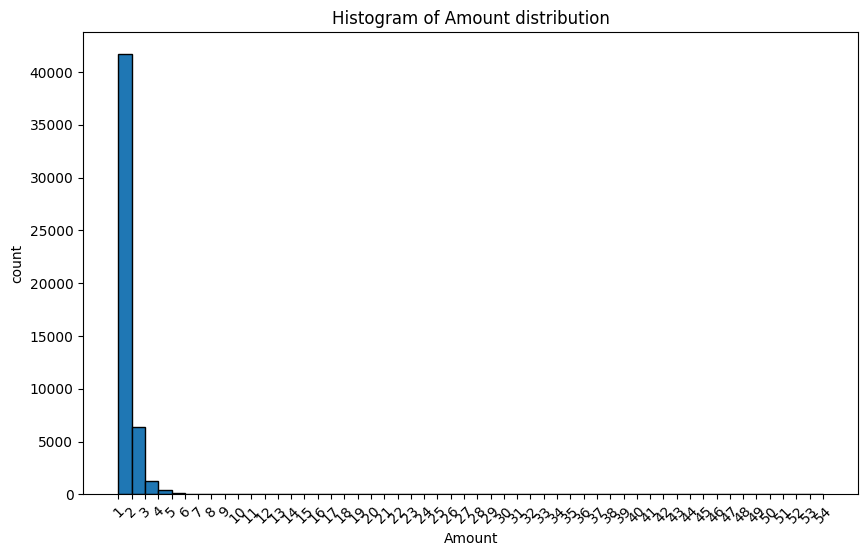

In [94]:
#Visualise distribution of Amount
plt.figure(figsize = (10,6))
plt.hist(df['Amount'], bins = range(1, df['Amount'].max() + 1), edgecolor = 'black')
plt.title('Histogram of Amount distribution')
plt.xlabel('Amount')
plt.ylabel('count')
plt.xticks(range(1, df['Amount'].max() + 1), rotation = 45)
plt.show()

Does 'Amount' refer to number of (different) items bought in that transaction, or number of same item? Look into relationship between Amount and Price for some products

In [95]:
product49291 = df[df['Code_Product'] == 49291.5]
product10013 = df[df['Code_Product'] == 10013.0]
product49291.head()

,Unnamed: 0,Main_ID,Transaction_ID,Date,Price,Code_Product,Amount
4,4,41949228,244fe6d8,2022-10-14 18:53:43.933,129.5,49291.5,5
5,5,0e816717,654c3866,2022-10-21 20:53:45.037,72.0,49291.5,1
18,18,4e30e4bd,e4e0995f,2022-09-13 18:06:33.157,59.0,49291.5,1
44,44,1914e5ad,c263f5ca,2022-11-27 14:34:39.030,19.5,49291.5,1
50,50,21e2aea9,69ef6992,2022-08-28 17:13:01.943,47.5,49291.5,1


The transaction IDS for this example Code_Product when Amount = 5 is unique, so Amount must be if that same product. Price doesn't seem to match up with simple Amount * (single unit price) however, with Amount = 5 for Code_Product 49291.5 $129.5 (on 2022-10-14), and a single unit $72 (on 2022-10-21). You;d expect single unit to be 129.5/5 = $25.9.


Could Price here reflect the single unit price? Have a look at how Price corresponds to amount for the top three most popular products

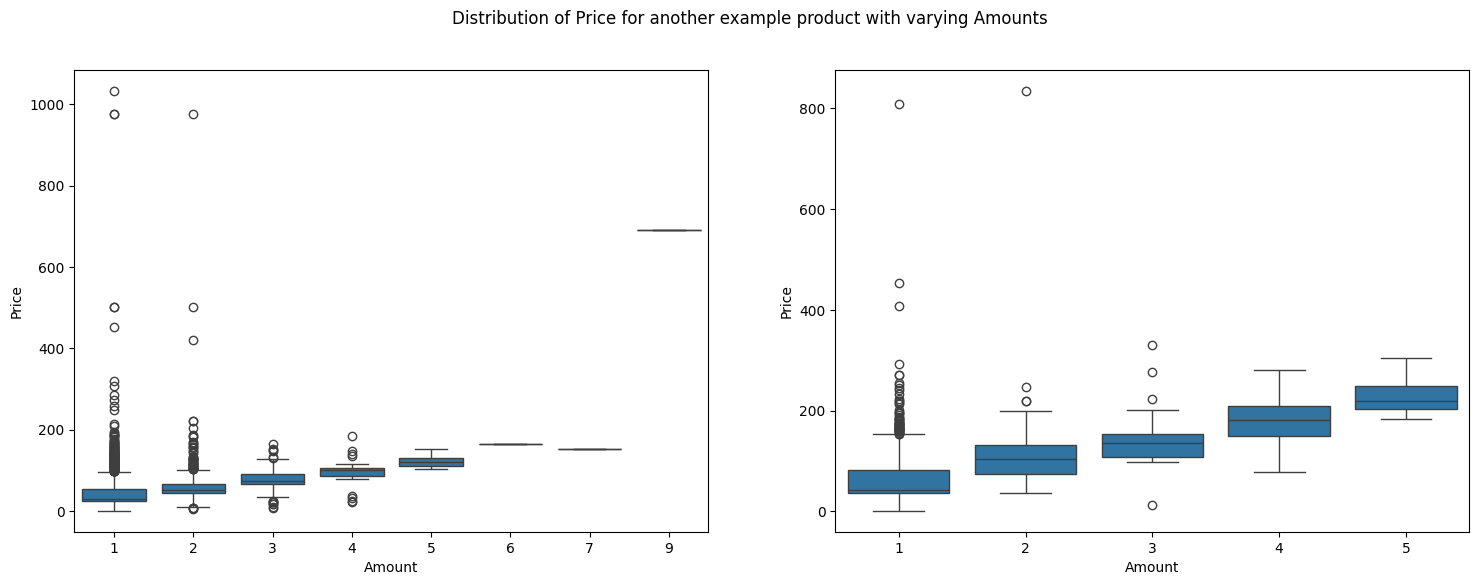

In [96]:
fig, axes = plt.subplots(1,2, figsize = (18,6))

sns.boxplot(x= 'Amount', y = 'Price', data = product49291, ax = axes[0])
sns.boxplot(x= 'Amount', y = 'Price', data = product10013, ax = axes[1])
fig.suptitle('Distribution of Price for another example product with varying Amounts') # set to centre of figure
plt.show()



Check the medians for each Amount value per product, looks like they're scaling nicely here so Amount indicates the amount of that product bought in that transaction.

In [97]:
product10013.groupby('Amount')['Price'].median()

Amount
1     43.50
2    104.00
3    136.50
4    180.50
5    219.25
Name: Price, dtype: float64

Lots of variability in single unit cost, but when looking at medians it looks like the prices scale nicely with the amount

## Transaction_ID data

In [98]:
transaction_id_counts = df['Transaction_ID'].value_counts()
transaction_id_counts.value_counts()

count
1    46859
2     1491
3       53
Name: count, dtype: int64

We have 1491 duplicated Transaction_IDs, 53 with three records. Check the duplicated transaction IDs occured from same customer on same day/time, and refer to customer purchasing more than one product

In [99]:
transaction_duplicates = df[df['Transaction_ID'].duplicated(keep = False)]

In [100]:
transaction_duplicates.sort_values(by= 'Transaction_ID')

,Unnamed: 0,Main_ID,Transaction_ID,Date,Price,Code_Product,Amount
12373,12373,7d7ea3d3,00647a4d,2022-11-21 17:28:34.180,189.0,10003.0,1
49616,49616,7d7ea3d3,00647a4d,2022-11-21 17:28:34.180,189.0,45001.5,2
3447,3447,04ca2e79,00a29b9f,2022-10-22 18:45:20.490,133.5,49292.0,2
36284,36284,04ca2e79,00a29b9f,2022-10-22 18:45:20.490,133.5,49292.0,2
24715,24715,367d45d1,00f59200,2022-10-06 15:09:53.273,50.5,5009.0,1
...,...,...,...,...,...,...,...
26328,26328,825af057,fff34fc5,2022-10-27 13:27:00.670,274.0,10023.5,2
34547,34547,825af057,fff34fc5,2022-10-27 13:27:00.670,274.0,25005.0,1
22348,22348,8e5994b0,fff7818d,2022-11-19 16:02:23.617,93.5,5002.0,1
33766,33766,8e5994b0,fff7818d,2022-11-19 16:02:23.617,93.5,5011.5,1


For transaction duplicates, customer and date are always the same, price is also the same only Code_Product is different. The duplicated transaction IDs therefore show **different products purchased at the same time by the same customer**, the price is the **aggregate of the all the code_products in the transcation as well as the and amount**.

## What are the most popular products? Could be 'null' recommendation e.g. for new users

In [101]:
popular_products = df.groupby('Code_Product')['Amount'].sum().sort_values(ascending = False)
popular_products.head()

Code_Product
49292.0    6006
49291.5    5706
5000.5     4730
45004.0    4507
10013.0    1713
Name: Amount, dtype: int32

## Have a look at aggregate data grouped by customer

In [102]:
df['Date'] = pd.to_datetime(df['Date'])

In [103]:
last_date = df['Date'].max()

customer_freq_spend_date = df.groupby('Main_ID').agg(
    Total_Spend=pd.NamedAgg(column='Price', aggfunc='sum'),
    Days_Since_Last_Purchase=pd.NamedAgg(column='Date', aggfunc=lambda x: (last_date - x.max()).days),
    Purchase_Count=pd.NamedAgg(column='Date', aggfunc='count')
)
customer_freq_spend_date.sort_values(by= 'Total_Spend', ascending= False).head()

,Total_Spend,Days_Since_Last_Purchase,Purchase_Count
Main_ID,,,
751131ee,28082.5,4,51
c25c373a,19561.5,74,25
31812c26,11399.5,80,19
4493b2ac,6318.5,1,35
0c87428f,6065.0,10,19


## Create pivot table for understanding relationship between customer and products they buy

In [104]:
cust_item_pivot = pd.pivot_table(df, values = 'Amount', index = 'Main_ID', columns = 'Code_Product', aggfunc = 'sum', fill_value = 0) 
cust_item_pivot

Code_Product,5000.5,5001.0,5001.5,5002.0,5002.5,5003.0,5004.0,5004.5,5005.0,5007.0,...,200035.5,200037.0,200037.5,200038.0,200038.5,200045.5,200046.0,200046.5,200047.0,350027.5
Main_ID,,,,,,,,,,,,,,,,,,,,,
00024de6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00084856,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0008e848,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00096930,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000c66b7,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff8b1c4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fff905d0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fff9726b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [105]:
item_cust_pivot = cust_item_pivot.T

In [106]:
# Generate a dot product matrix to show which products are co-occuring more or less across each customer (mostly across different transactions, sometimes same transaction - we just sum them above/don't treat them differently)
co_occur_matrix = np.dot(item_cust_pivot, cust_item_pivot)

In [107]:
len(co_occur_matrix) # matches the number of products

333

In [108]:
co_occur_df = pd.DataFrame(co_occur_matrix,
                           index = item_cust_pivot.index,
                           columns = item_cust_pivot.index
                           )

In [109]:
co_occur_df.head()

Code_Product,5000.5,5001.0,5001.5,5002.0,5002.5,5003.0,5004.0,5004.5,5005.0,5007.0,...,200035.5,200037.0,200037.5,200038.0,200038.5,200045.5,200046.0,200046.5,200047.0,350027.5
Code_Product,,,,,,,,,,,,,,,,,,,,,
5000.5,13022,695,325,675,0,8,1,104,83,27,...,0,0,0,0,0,0,0,0,0,0
5001.0,695,1197,68,192,0,1,0,35,69,9,...,0,0,0,0,0,0,0,0,0,0
5001.5,325,68,674,50,0,2,1,3,9,10,...,0,0,0,0,0,0,0,0,0,0
5002.0,675,192,50,1308,0,6,0,27,16,3,...,0,0,0,0,0,0,0,0,0,0
5002.5,0,0,0,0,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


With the co-occurrence or similarity matrix in hand:

- Identify items each user already purchased by iterating over user_item_pivot.
- For each purchased item, look up the top-N similar items from the co_occurrence_df.
- Collect these candidate items, sort by highest co-occurrence, and exclude items the user already has to avoid recommending duplicates.

In [110]:
def recommend_items(cust_id, cust_item_data, co_occurence_data, top_n=3):
    # get items purchased by the user
    purchased_items = cust_item_data.columns[cust_item_data.loc[cust_id] > 0]
    
    # For every item the user purchased, get co-occurance scores from the co-occurance data
    similar_candidates = {}
    
    for item in purchased_items:
        # Sort items by similarity score descending
        sim_scores = co_occurence_data.loc[item].sort_values(ascending=False)
        for candidate_item, score in sim_scores.items():
            # Skip if it's the item itself or already purchased
            if candidate_item == item or candidate_item in purchased_items:
                continue
            similar_candidates[candidate_item] = max(similar_candidates.get(candidate_item, 0), score) # get the item with the highest similarity score for that product
    
    # Sort candidates by max similarity (co-occurence)
    sorted_candidates = sorted(similar_candidates.items(), key=lambda x: x[1], reverse=True)
    
    # Pick the top_n as the top recommendations (default, three recommendations - can change this if we want more)
    top_recs = [item for item, score in sorted_candidates[:top_n]]
    return top_recs

# Create a dictinary of customer and top_n recommended items
all_recommendations = {}
for cust in cust_item_pivot.index:
    recs = recommend_items(
        cust_id=cust, 
        cust_item_data=cust_item_pivot, 
        co_occurence_data= co_occur_df, 
        top_n=3
    )
    all_recommendations[cust] = recs

In [111]:
# create final df with customer Id and recommended items
recs_df = pd.DataFrame([
    {'Main_ID': user, 'Recommended_Items': all_recommendations[user]} 
    for user in all_recommendations
])

In [112]:
recs_df.head()

,Main_ID,Recommended_Items
0,00024de6,"[35001.0, 35096.5, 5000.5]"
1,00084856,"[5000.5, 45004.0, 10013.0]"
2,0008e848,"[5000.5, 45004.0, 49291.5]"
3,00096930,"[49292.0, 5000.5, 45004.0]"
4,000c66b7,"[5000.5, 45004.0, 49292.0]"


In [ ]:
# Split Recommnded_Items list into three separate columns
recs_df[['rec1','rec2','rec3']] = pd.DataFrame(recs_df['Recommended_Items'].to_list(), index = recs_df.index)
recs_df.drop('Recommended_Items', axis = 1, inplace = True)                       

In [114]:
recs_df.head() 

,Main_ID,rec1,rec2,rec3
0,00024de6,35001.0,35096.5,5000.5
1,00084856,5000.5,45004.0,10013.0
2,0008e848,5000.5,45004.0,49291.5
3,00096930,49292.0,5000.5,45004.0
4,000c66b7,5000.5,45004.0,49292.0


In [134]:
 recs_df[['rec1', 'rec2', 'rec3']].eq(35001.0).sum()

rec1    47
rec2     7
rec3    63
dtype: int64